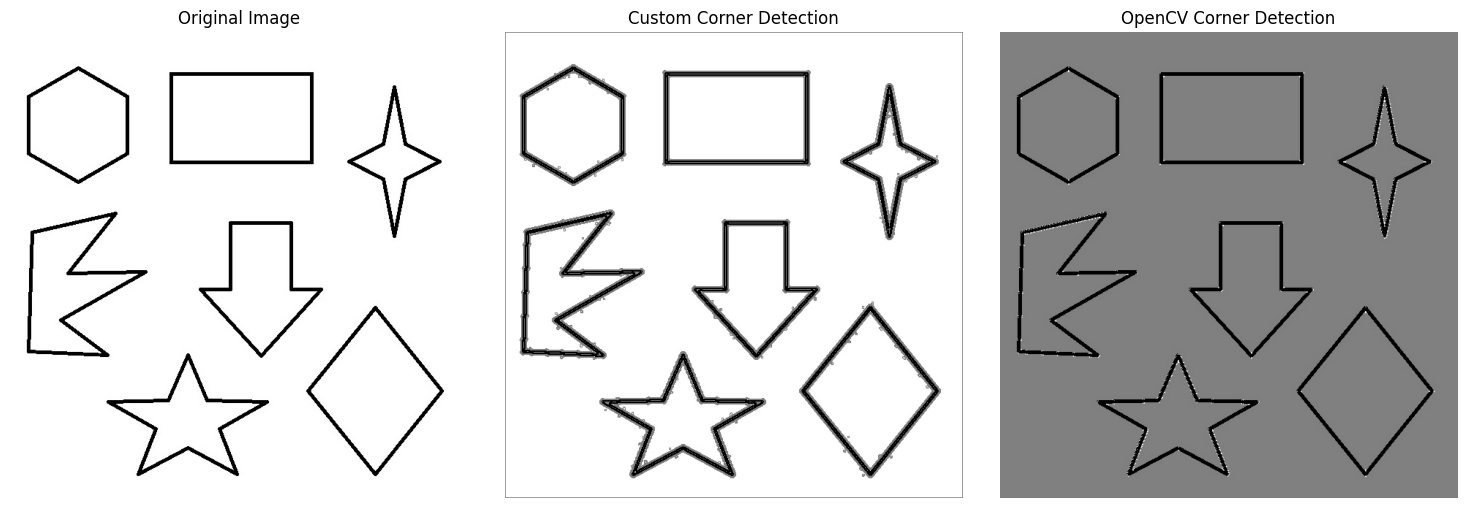

[ WARN:0@4.941] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


True

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def my_harris_corner_detector(image, k=0.04, window_size=3, threshold=0.01):
    """
    Custom implementation of Harris corner detection
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    gray = np.float32(gray)
    
    # Step 1: Compute gradients
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Step 2: Compute products of derivatives
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy
    
    # Step 3: Compute sums of products of derivatives using a window
    offset = window_size // 2
    height, width = gray.shape
    R = np.zeros_like(gray)
    
    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            # Window sums
            Sx2 = np.sum(Ix2[y-offset:y+offset+1, x-offset:x+offset+1])
            Sy2 = np.sum(Iy2[y-offset:y+offset+1, x-offset:x+offset+1])
            Sxy = np.sum(Ixy[y-offset:y+offset+1, x-offset:x+offset+1])
            
            # Harris response
            det = (Sx2 * Sy2) - (Sxy ** 2)
            trace = Sx2 + Sy2
            R[y, x] = det - k * (trace ** 2)
    
    # Step 4: Normalize and threshold
    R = (R - R.min()) / (R.max() - R.min())
    corners = np.zeros_like(R)
    corners[R > threshold] = 255
    
    # Step 5: Non-maximum suppression
    # Find local maxima
    corners_nms = np.zeros_like(corners)
    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            if corners[y, x] == 255:
                local_patch = R[y-offset:y+offset+1, x-offset:x+offset+1]
                if R[y, x] == np.max(local_patch):
                    corners_nms[y, x] = 255
    
    return corners_nms

# Load the image
image = cv2.imread('corner.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Custom corner detection
custom_corners = my_harris_corner_detector(gray, threshold=0.02)

# OpenCV's Harris corner detection
cv_corners = np.zeros_like(gray)
dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
cv_corners[dst > 0.01 * dst.max()] = 255

# Create output directory
output_dir = './'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imshow(custom_corners, cmap='gray', alpha=0.5)
plt.title('Custom Corner Detection')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imshow(cv_corners, cmap='gray', alpha=0.5)
plt.title('OpenCV Corner Detection')
plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'corner_comparison.png'))
plt.show()

# Save individual results
cv2.imwrite(os.path.join(output_dir, 'original.jpg'), image)
cv2.imwrite(os.path.join(output_dir, 'custom_corners.jpg'), custom_corners)
cv2.imwrite(os.path.join(output_dir, 'opencv_corners.jpg'), cv_corners)